In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.utils import make_grid
from torch._jit_internal import weak_module, weak_script_method

import numpy as np
from imageio import imread
import scipy.misc as m
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)

from pathlib import Path
from tqdm import tqdm
import os

In [2]:
def recursive_glob(rootdir=".", suffix=""):
    """Performs recursive glob with given suffix and rootdir
        :param rootdir is the root directory
        :param suffix is the suffix to be searched
    """
    return [
        os.path.join(looproot, filename)
        for looproot, _, filenames in os.walk(rootdir)
        for filename in filenames
        if filename.endswith(suffix)
    ]

In [250]:
class CityScapesDataset(Dataset):
    colors = [  # [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [0, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]
    
    label_colours = dict(zip(range(19), colors))
    
    def __init__(self, 
                 root, 
                 split='train', 
                 is_transform=False,
                 img_size=(256, 256),
                 img_norm=True,
                 test_mode=False):
        self.root = root
        self.split = split
        self.is_transform = is_transform
        self.img_norm = img_norm
        self.n_classes = 19
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.files = {}
        
        self.images_base = os.path.join(self.root, "leftImg8bit", self.split)
        self.annotations_base = os.path.join(self.root, "gtFine", self.split)
        
        self.files[split] = recursive_glob(rootdir=self.images_base, suffix=".png")

        self.void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
        self.valid_classes = [
            7,
            8,
            11,
            12,
            13,
            17,
            19,
            20,
            21,
            22,
            23,
            24,
            25,
            26,
            27,
            28,
            31,
            32,
            33,
        ]
        self.class_names = [
            "unlabelled",
            "road",
            "sidewalk",
            "building",
            "wall",
            "fence",
            "pole",
            "traffic_light",
            "traffic_sign",
            "vegetation",
            "terrain",
            "sky",
            "person",
            "rider",
            "car",
            "truck",
            "bus",
            "train",
            "motorcycle",
            "bicycle",
        ]

        self.ignore_index = 250
        self.class_map = dict(zip(self.valid_classes, range(19)))
        
        if not self.files[split]:
            raise Exception("No files for split=[%s] found in %s" % (split, self.images_base))

        print("Found %d %s images" % (len(self.files[split]), split))
        
    def __len__(self):
        return len(self.files[self.split])
    
    def __getitem__(self, index):
        img_path = self.files[self.split][index].rstrip()
        lbl_path = os.path.join(
            self.annotations_base,
            img_path.split(os.sep)[-2],
            os.path.basename(img_path)[:-15] + "gtFine_labelIds.png",
        )
        
        img = imread(img_path)
        img = np.array(img, dtype=np.uint8)

        lbl = imread(lbl_path)
        lbl = self.encode_segmap(np.array(lbl, dtype=np.uint8))
        
        if self.is_transform:
            img, lbl = self.transform(img, lbl)
        lbl = lbl.unsqueeze(0)
        lbl = lbl.float()
        return img, lbl
    
    def decode_segmap(self, temp):
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = self.label_colours[l][0]
            g[temp == l] = self.label_colours[l][1]
            b[temp == l] = self.label_colours[l][2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb

    def encode_segmap(self, mask):
        # Put all void classes to zero
        for _voidc in self.void_classes:
            mask[mask == _voidc] = self.ignore_index
        for _validc in self.valid_classes:
            mask[mask == _validc] = self.class_map[_validc]
        return mask
    
    def transform(self, img, lbl):
        """transform
        :param img:
        :param lbl:
        """
#         img = np.array(Image.fromarray(img).resize((self.img_size[0], self.img_size[1])))
        img = m.imresize(img, (self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float64)
        if self.img_norm:
            # Resize scales images from 0 to 255, thus we need
            # to divide by 255.0
            img = img.astype(float) / 255.0
        # NHWC -> NCHW
        img = img.transpose(2, 0, 1)

        classes = np.unique(lbl)
        lbl = lbl.astype(float)
        lbl = m.imresize(lbl, (self.img_size[0], self.img_size[1]), "nearest", mode="F")
        lbl = lbl.astype(int)

        if not np.all(classes == np.unique(lbl)):
            print("WARN: resizing labels yielded fewer classes")

        if not np.all(np.unique(lbl[lbl != self.ignore_index]) < self.n_classes):
            print("after det", classes, np.unique(lbl))
            raise ValueError("Segmentation map contained invalid class values")

        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()
        
        return img, lbl

In [251]:
path = '../../Data/City Scape Dataset/'
dataset = {
    x: CityScapesDataset(path, split=x, is_transform=True) for x in ['train', 'val']
}

Found 2975 train images
Found 500 val images


In [252]:
data = {
    x: DataLoader(dataset[x], 
                  batch_size=4, 
                  shuffle=True, 
                  num_workers=8) for x in ['train', 'val']
}

In [253]:
iterator = iter(data['train'])

/home/kushaj/anaconda3/envs/PyTorch/lib/python3.7/site-packages/ipykernel_launcher.py:151: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/home/kushaj/anaconda3/envs/PyTorch/lib/python3.7/site-packages/ipykernel_launcher.py:151: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/home/kushaj/anaconda3/envs/PyTorch/lib/python3.7/site-packages/ipykernel_launcher.py:151: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/home/kushaj/anaconda3/envs/PyTorch/lib/python3.7/site-packages/ipykernel_launcher.py:151: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1

WARN: resizing labels yielded fewer classes


/home/kushaj/anaconda3/envs/PyTorch/lib/python3.7/site-packages/ipykernel_launcher.py:166: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


WARN: resizing labels yielded fewer classes


In [254]:
img, seg = next(iterator)

In [255]:
img.size()

torch.Size([4, 3, 256, 256])

In [256]:
seg.size()

torch.Size([4, 1, 256, 256])

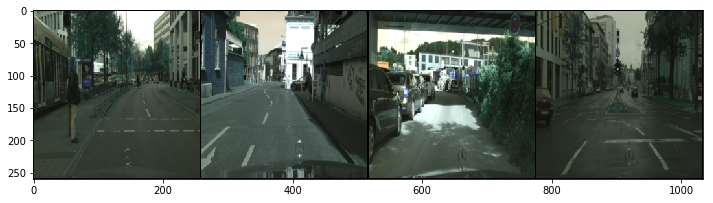

In [257]:
plt.rcParams['figure.figsize'] = (12, 6)
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.pause(0.001)
    
grid_img = make_grid(img, nrow=4)
imshow(grid_img)

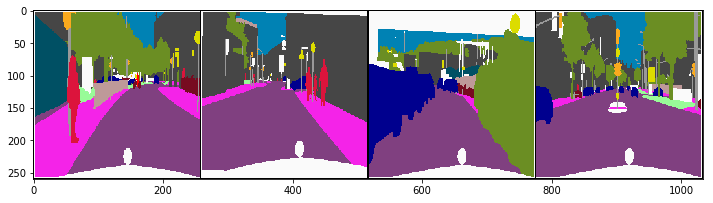

In [258]:
segmap = torch.zeros(4, 3, 256, 256)
for i, a in enumerate(seg):
    image = a.squeeze()
    image = image.numpy()
    image = dataset['train'].decode_segmap(image)
    image = image.transpose((2, 0, 1))
    image = torch.from_numpy(image)
    segmap[i] = image
    
def imshow(image):
    image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image)
    plt.pause(0.001)
    
grid_img = make_grid(segmap, nrow=4)
imshow(grid_img)

## SPADE Normalization Layer

In [259]:
class SPADE(nn.Module):
    def __init__(self, k):
        # Explanation of the conv layer attributes
        # 1. kernel_size = (3, 3). In the paper they experimented and chose 3x3.
        # 5x5 gives similiar performance
        # 2. Padding=1 is used to keep the size of the feature maps same (i.e if
        # input is of size (128, 128, 3) then after conv layer it will still
        # be (128, 128, 3))
        # 3. The in_channels=1 for self.conv because the seg map has 1 dim
        # 4 The mid_channels=128 From the paper
        # 5. k -> The number of channels that the activation map has (in our case
        # the number of channels that x has in the forward)
        super().__init__()
        self.conv = nn.Conv2d(1, 128, kernel_size=(3, 3), padding=1)
        self.conv_gamma = nn.Conv2d(128, k, kernel_size=(3, 3), padding=1)
        self.conv_beta = nn.Conv2d(128, k, kernel_size=(3, 3), padding=1)
    
    def forward(self, x, seg):
        # Store the sizes for easy reference
        N, C, H, W = x.size()
        
        # Apply Normalization for the input activations i.e. x
        # To compute the sum faster I combine the height and width, as I can
        # access the last dim easily with dim=-1
        
        # Compute the mean and std. Direct formulas are used. One modification
        # that you can do here, is to store the running mean and std as in the
        # pytorch BatchNorm layer. Implementation of that is also, easy a quick
        # look at the batchnorm source code would be sufficient.
        sum_channel = torch.sum(x.reshape(N, C, H*W), dim=-1)
        mean = sum_channel / (N*H*W)
        std = torch.sqrt((sum_channel**2 - mean**2) / (N*H*W))
        
        # Pytorch broadcasting words from the tail side. So for example if I have
        # two inputs of dim (4, 3) and (4, 3, 256, 256). PyTorch would expand the 
        # first input of (4, 3) dim as (1, 1, 4, 3). So to prevent it and use 
        # torch broadcasting I use unsqueeze twice to make it (4, 3, 1, 1)
        mean = torch.unsqueeze(torch.unsqueeze(mean, -1), -1)
        std = torch.unsqueeze(torch.unsqueeze(std, -1), -1)
        x = (x - mean)/std
        
        # Apply conv layers to the segmentation map
        # The first step is to make the segmentation map the same size as activations
        # i.e x. We will use nearest-neighbour upsampling, as we don't want to introduce
        # new terms in the segmentation map (remember every value in the segmentation map
        # corresponds to a class and we cannot create new values as they would not 
        # correspond to any class). nearest-neighbour simply repeats the neighbouring
        # values, thus not introducing new terms.
        seg = F.interpolate(seg, size=(H, W), mode='nearest')
        seg = F.relu(self.conv(seg))
        seg_gamma = self.conv_gamma(seg)
        seg_beta = self.conv_beta(seg)
        
        # Apply the rescaling
        x = torch.matmul(seg_gamma, x) + seg_beta
        
        return x

In [260]:
spadenorm = SPADENorm(3)

In [261]:
out = spadenorm(img, seg)

In [262]:
out.size()

torch.Size([4, 3, 256, 256])